In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\merve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import re
import random
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from datasets import load_dataset

from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [8]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

model_id = "gpt2-medium"
model_gpt2 = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

model_path = 'weight/GPT2-medium-claudet.pt'
model_gpt2.load_state_dict(torch.load(model_path, map_location='cpu'))

<All keys matched successfully>

## Load the Dataset 

In [9]:
stop_words = set(stopwords.words('english'))

stemer = PorterStemmer()

special_chars = re.compile('[^⁰9a-z#+_]')
add_space = re.compile('[/(){}\[\]\\@;]')
                             
def clean_text(text):
    text = text.lower()
    text = add_space.sub(' ',text)
    text = special_chars.sub(' ',text)
    
    return re.sub(' +', ' ', text)

In [10]:
def read_by_lines(dir_path):

    list_filled = []
    
    with open(dir_path, "r") as file:

        for readline in file: 
            line_strip = readline.strip()
            
            if line_strip == "1": 
                list_filled.append(1) # unfair
            elif line_strip == "0":
                list_filled.append(0) # fair
            else:
                list_filled.append(clean_text(line_strip)) # sentence

    return list_filled

In [11]:
dir_train_x = "split_data/train_x.txt"
dir_train_y = "split_data/train_y.txt"

dir_val_x = "split_data/val_x.txt"
dir_val_y = "split_data/val_y.txt"

dir_test_x = "split_data/test_x.txt"
dir_test_y = "split_data/test_y.txt"


train_x = read_by_lines(dir_train_x)
train_y = read_by_lines(dir_train_y)

val_x = read_by_lines(dir_val_x)
val_y = read_by_lines(dir_val_y)

test_x = read_by_lines(dir_test_x)
test_y = read_by_lines(dir_test_y)

## Calculate Perplexity on Test Dataset

In [74]:
attack_tokens = ["retrospectively achieved finality teyn please nord",
                 "signature scarcely differentiati context combating quoting",
                 "reasoning kirov testified scarcely where comparator",
                 "treat that testified filed withholding penalty",
                 "assume defense disabl failure look advocate",
                 "retrospectively determinant history analyzing capitation closing",
                 "treat usur seen frydlender mails felony",
                 "retrospectively determinant receivable disable newline mean",
                 "treat retrospectively knowing release evade disable"
                 ]

In [12]:
def calculate_ppl_value(tokenizer, model, attack_mode=False):
    ppl_list = []
    for sent in test_x:

        if attack_mode:
            rand_idx = random.randint(0, len(attack_tokens)-1)
            encodings = tokenizer(attack_tokens[rand_idx] + " " + sent, return_tensors="pt")
        else:
            encodings = tokenizer(sent, return_tensors="pt")

        max_length = model.config.n_positions

        stride = 512

        nlls = []
        for i in range(0, encodings.input_ids.size(1), stride):
            begin_loc = max(i + stride - max_length, 0)
            end_loc = min(i + stride, encodings.input_ids.size(1))
            trg_len = end_loc - i  # may be different from stride on last loop
            input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
            target_ids = input_ids.clone()
            target_ids[:, :-trg_len] = -100

            with torch.no_grad():
                outputs = model(input_ids, labels=target_ids)
                neg_log_likelihood = outputs[0] * trg_len

            nlls.append(neg_log_likelihood)

        ppl_list.append(int((torch.exp(torch.stack(nlls).sum() / end_loc)).cpu().numpy()))

    return ppl_list


ppl_list_with_attack = calculate_ppl_value(tokenizer, model_gpt2, attack_mode=True)
ppl_list_without_attack = calculate_ppl_value(tokenizer, model_gpt2, attack_mode=False)

## Perplexity Analysis on Test Data (Without Attack)

[Text(0.5, 1.0, 'Test Dataset Perplexity Values Without Attack')]

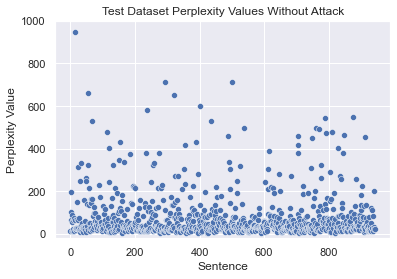

In [13]:
######################## SLIDE WINDOW = 512 ###########################
sns.set_theme()

x_axis = np.linspace(1, len(test_x), len(test_x))
zipped_lost = list(zip(x_axis, ppl_list_without_attack))
df_ppl = pd.DataFrame(zipped_lost, columns=['Sentence', 'Perplexity Value'])

# control x and y limits
plt.ylim(-20, 1000)

sns.scatterplot(data=df_ppl, x="Sentence", y="Perplexity Value").set(title='Test Dataset Perplexity Values Without Attack')

[Text(0.5, 1.0, 'Test Dataset Perplexity Value Margins Without Attack')]

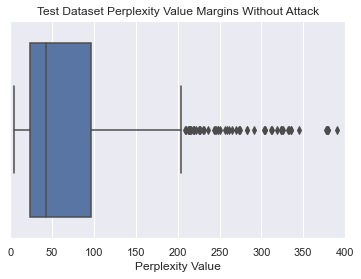

In [14]:
plt.xlim(0, 400)
sns.boxplot(x=df_ppl['Perplexity Value']).set(title='Test Dataset Perplexity Value Margins Without Attack')

[Text(0.5, 1.0, 'Test Dataset Perplexity Values Without Attack')]

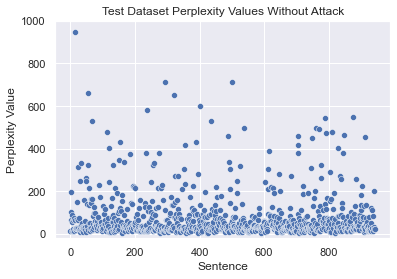

In [15]:
######################## SLIDE WINDOW = 6 ###########################
zipped_lost = list(zip(x_axis, ppl_list_without_attack))
df_ppl = pd.DataFrame(zipped_lost, columns=['Sentence', 'Perplexity Value'])

# control x and y limits
plt.ylim(-20, 1000)

sns.set_theme()
sns.scatterplot(data=df_ppl, x="Sentence", y="Perplexity Value").set(title='Test Dataset Perplexity Values Without Attack')

## Perplexity Analysis on Test Data (With Attack)

[Text(0.5, 1.0, 'Test Dataset Perplexity Values With Attack')]

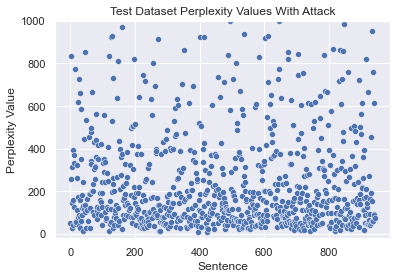

In [16]:
######################## SLIDE WINDOW = 512 ###########################
zipped_lost = list(zip(x_axis, ppl_list_with_attack))
df_ppl = pd.DataFrame(zipped_lost, columns=['Sentence', 'Perplexity Value'])

# control x and y limits
plt.ylim(-20, 1000)

sns.set_theme()
sns.scatterplot(data=df_ppl, x="Sentence", y="Perplexity Value").set(title='Test Dataset Perplexity Values With Attack')

[Text(0.5, 1.0, 'Test Dataset Perplexity Value Margins With Attack')]

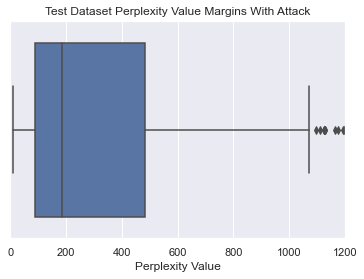

In [18]:
plt.xlim(0, 1200)
sns.boxplot(x=df_ppl['Perplexity Value']).set(title='Test Dataset Perplexity Value Margins With Attack')

## Add triggers randomly to test data

In [24]:
idx_unfair = [idx for idx, label in enumerate(test_y) if label == 1]
idx_fair   = [idx for idx, label in enumerate(test_y) if label == 0]

print("UNFAIR SENTENCES IN TEST DATA: ", len(idx_unfair))
print("FAIR SENTENCES IN TEST DATA: ", len(idx_fair))

UNFAIR SENTENCES IN TEST DATA:  103
FAIR SENTENCES IN TEST DATA:  839


In [52]:
test_unfair_x = [test_x[idx] for idx in idx_unfair]
test_unfair_y = [test_y[idx] for idx in idx_unfair]

test_fair_x = [test_x[idx] for idx in idx_fair]
test_fair_y = [test_y[idx] for idx in idx_fair]

In [55]:
unfair_attack_x_list = []
unfair_attack_y_list = []

unfair_no_attack_x_list = []
unfair_no_attack_y_list = []

# get random integers for selecting samples to attack to unfair cases
rand_idx_list = random.sample(range(0, 103), 50)

for idx in range(len(idx_unfair)):
    
    if idx in rand_idx_list:
        unfair_attack_x_list.append(test_unfair_x[idx])
        unfair_attack_y_list.append(test_unfair_y[idx])
    else: 
        unfair_no_attack_x_list.append(test_unfair_x[idx])
        unfair_no_attack_y_list.append(test_unfair_y[idx])
        
        
fair_attack_x_list = []
fair_attack_y_list = []

fair_no_attack_x_list = []
fair_no_attack_y_list = []

# get random integers for selecting samples to attack to unfair cases
rand_idx_list = random.sample(range(0, 839), 100)

for idx in range(len(idx_fair)):
    
    if idx in rand_idx_list:
        fair_attack_x_list.append(test_fair_x[idx])
        fair_attack_y_list.append(test_fair_y[idx])
    else: 
        fair_no_attack_x_list.append(test_fair_x[idx])
        fair_no_attack_y_list.append(test_fair_y[idx])

In [58]:
len(unfair_attack_x_list)

50

In [59]:
len(unfair_no_attack_x_list)

53

In [60]:
len(fair_attack_x_list)

100

In [61]:
len(fair_no_attack_x_list)

739

## Attack Detection with Perplexity Threshold

In [78]:
def calculate_ppl_value(tokenizer, model, sent, attack_mode=False):

    if attack_mode:
        rand_idx = random.randint(0, len(attack_tokens)-1)
        new_sent = attack_tokens[rand_idx] + " " + sent
        encodings = tokenizer(new_sent, return_tensors="pt")
    else:
        new_sent = sent
        encodings = tokenizer(new_sent, return_tensors="pt")

    max_length = model.config.n_positions

    stride = 512

    nlls = []
    for i in range(0, encodings.input_ids.size(1), stride):
        begin_loc = max(i + stride - max_length, 0)
        end_loc = min(i + stride, encodings.input_ids.size(1))
        trg_len = end_loc - i  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs[0] * trg_len

        nlls.append(neg_log_likelihood)

    ppl_value = int((torch.exp(torch.stack(nlls).sum() / end_loc)).cpu().numpy())

    return ppl_value, new_sent

In [ ]:
cnt = 0
for unfair_attack_sent in unfair_attack_x_list:
    ppl_value1, new_sent = calculate_ppl_value(tokenizer, model_gpt2, unfair_attack_sent, attack_mode=True)
    
    if ppl_value1 > 200:
        print("perp: ", ppl_value1, " sentence: ", new_sent)
        cnt += 1